In [1]:
#!pip install jovian --upgrade --quiet
#!pip install torch
#!pip install torchtext

In [275]:
import os
import jovian
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

In [276]:
data_dir = './data'
print(os.listdir(data_dir))
data_file = './data/Sarcasm_Headlines_Dataset_V2.json'

['Sarcasm_Headlines_Dataset_v2.json', 'test.json', 'train.json', 'val.json']


In [277]:
table = []
with open(data_file, 'r') as f:
    for line in f:
        table.append(json.loads(line))
for i in range(0, 9):
    print(table[i], '\n')

{'is_sarcastic': 1, 'headline': 'thirtysomething scientists unveil doomsday clock of hair loss', 'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'} 

{'is_sarcastic': 0, 'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality', 'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'} 

{'is_sarcastic': 0, 'headline': 'eat your veggies: 9 deliciously different recipes', 'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'} 

{'is_sarcastic': 1, 'headline': 'inclement weather prevents liar from getting to work', 'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'} 

{'is_sarcastic': 1, 'headline': "mother comes pretty close to using word 'streaming' correctly", 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-s

In [278]:
tokenize = lambda x: x.split()

headline = Field(sequential=True, 
                 use_vocab=True, 
                 tokenize=tokenize, 
                 lower=True)

is_sarcastic = Field(sequential=False,
                     use_vocab=False,
                     pad_token=None, 
                     unk_token=None)

fields = {'headline':('headline', headline),
          'is_sarcastic':('sarcasm', is_sarcastic)}

train, val = TabularDataset.splits(path='./data',
                                   train='train.json',
                                   test = 'val.json',
                                   format='json',
                                   fields=fields)
test = TabularDataset(path='./data/test.json',
                      format='json',
                      fields=fields)

print(len(train), len(val), len(test))
print(train.fields.items())
print(type(train[0]))
print(train[0].headline, train[0].sarcasm)

25748 2860 8
dict_items([('headline', <torchtext.data.field.Field object at 0x000001B507BF9D88>), ('sarcasm', <torchtext.data.field.Field object at 0x000001B507BF9DC8>)])
<class 'torchtext.data.example.Example'>
['far,', 'far', 'away', 'in', 'a', 'galaxy,', "there's", 'lots', 'of', 'room', 'for', '#starwarschristmascarols'] 0


In [279]:
headline.build_vocab(train, max_size=10000, min_freq=1)
print(headline.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001B507BF9088>>, {'<unk>': 0, '<pad>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'man': 13, 'from': 14, 'at': 15, 'trump': 16, 'about': 17, 'by': 18, 'after': 19, 'you': 20, 'this': 21, 'be': 22, 'as': 23, 'that': 24, 'out': 25, 'how': 26, 'up': 27, 'it': 28, 'not': 29, 'he': 30, 'your': 31, 'are': 32, 'his': 33, 'just': 34, 'who': 35, 'what': 36, 'has': 37, 'will': 38, 'all': 39, 'into': 40, 'more': 41, 'have': 42, 'over': 43, 'one': 44, 'area': 45, 'why': 46, 'woman': 47, 'can': 48, 'says': 49, 'donald': 50, 'report:': 51, 'u.s.': 52, 'day': 53, 'time': 54, 'get': 55, 'like': 56, 'her': 57, "trump's": 58, 'first': 59, 'an': 60, 'no': 61, 'now': 62, 'off': 63, 'people': 64, 'still': 65, 'house': 66, 'make': 67, 'white': 68, 'than': 69, 'was': 70, 'obama': 71, 'if': 72, 'my': 73, 'back': 74, 'life': 75, 'women': 76, 'down': 77, 

In [280]:
train_iterator, val_iterator = Iterator.splits((train, val), 
                                                batch_sizes=(2, 2),
                                                sort_key=lambda x: len(x.headline),
                                                sort_within_batch=False)
test_iterator = Iterator(test,
                         batch_size=1,
                         repeat=False,
                         shuffle=False)

print(len(train_iterator), len(val_iterator), len(test_iterator))
for batch in train_iterator:
    print(batch.headline, batch.headline.shape)
    print(batch.sarcasm, batch.sarcasm.shape)
    break

12874 1430 8
tensor([[  38,    0],
        [   4,   98],
        [ 214,   38],
        [1225,  742],
        [2001,    4],
        [ 914,  408],
        [5738,  198]]) torch.Size([7, 2])
tensor([0, 0]) torch.Size([2])


In [281]:
class Wrapper:
    def __init__(self, iter, x_var, y_var):
        self.iter = iter
        self.x_var = x_var
        self.y_var = y_var
        
    def __iter__(self):
        for batch in self.iter:
            x = getattr(batch, self.x_var)
            
            if self.y_var is None:
                y = torch.zeros((1))
            else:
                y = getattr(batch, self.y_var)
            yield (x, y)

    def __len__(self):
        return len(self.iter)

train_dl = Wrapper(train_iterator, 'headline', 'sarcasm')
val_dl = Wrapper(val_iterator, 'headline', 'sarcasm')
test_dl = Wrapper(test_iterator, 'headline', 'sarcasm')

print(next(train_dl.__iter__()))

(tensor([[ 439, 2728],
        [4293, 5428],
        [ 110,    9],
        [ 443,   33],
        [ 247, 8963],
        [  34, 2414],
        [4626,   32],
        [1712,   74],
        [1685,    5],
        [ 579, 3667],
        [ 223, 5833],
        [  96, 2513],
        [   0, 3974],
        [  59,    1]]), tensor([1, 0]))


In [9]:
class SarcasmLogReg(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_dimension, nr_classes):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocabulary_size, embedding_dimension)
        self.fc = nn.Linear(embedding_dimension, nr_classes)
        
        self.embedding.weight.data.uniform_(-0.5, 0.5)
        self.fc.weight.data.uniform_(-0.5, 0.5)
        self.fc.bias.data.zero_()
        
    def forward(self, text):
        #print("Original: ", text.shape)
        #print(text)
        text = torch.transpose(text, 0, 1)
        #print("Transpose:     ", text.shape)
        #print(text)
        embedded = self.embedding(text)
        #print("Embedded: ", embedded.shape)
        #print(embedded)
        out = self.fc(embedded)
        #print("Linear: ",out.shape)
        #print(out)
        out = F.sigmoid(out)
        #print("Sigmoid: ",out.shape)
        #print(out)
        return out
    
    def training_step(self, batch):
        text, labels = batch 
        out = self(text)                    # Generate predictions
        out = torch.transpose(out, 0, 1)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        text, labels = batch 
        out = self(text)                      # Generate predictions
        out = torch.transpose(out, 0, 1)
        #print("Transpose:     ", out.shape)
        #print(out)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, epochs, lr, train_loader, val_loader, opt_func):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            opt_func.step()
            opt_func.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
vocabulary_size = len(headline.vocab)
embedding_dimension = 32
nr_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SarcasmLogReg(vocabulary_size, embedding_dimension, nr_classes).to(device)

In [12]:
epochs = 5
lr = 0.1

history = [evaluate(model, val_dl)]
print(history)

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 1e-3)
history += fit(model, epochs, lr, train_dl, val_dl, opt)

D:\Softwares\Anaconda\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[{'val_loss': 0.692183256149292, 'val_acc': 0.5171328783035278}]
Epoch [0], val_loss: 0.5910, val_acc: 0.7052
Epoch [1], val_loss: 0.5777, val_acc: 0.7157
Epoch [2], val_loss: 0.5724, val_acc: 0.7245
Epoch [3], val_loss: 0.5726, val_acc: 0.7248
Epoch [4], val_loss: 0.5729, val_acc: 0.7238


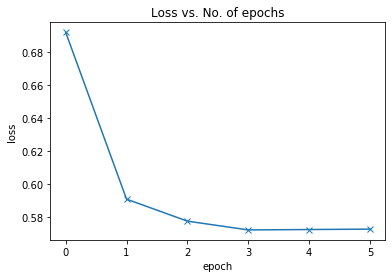

In [13]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

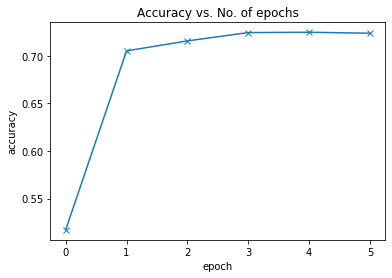

In [14]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [15]:
def predict(text, model):
    yb = model(text)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

for i, (text, label) in enumerate(test_dl):
    print(test[i].headline)
    print(text.view(1, text.shape[0]))
    print('Label:', label, ', Predicted:', predict(text, model), '\n')

['mom', 'starting', 'to', 'fear', "son's", 'web', 'series', 'closest', 'thing', 'she', 'will', 'have', 'to', 'grandchild']
tensor([[ 134,  672,    2, 1002, 1742, 2876,  627, 4540,  215,  107,   38,   42,
            2,    0]])
Label: tensor([1]) , Predicted: 1 

['man', 'having', 'a', 'great', 'time', 'will', 'soon', 'have', 'to', 'apologize', 'to', 'everyone']
tensor([[  13,  312,    7,  307,   54,   38, 1276,   42,    2, 3142,    2,  233]])
Label: tensor([1]) , Predicted: 1 

['police', 'use', 'exact', 'right', 'amount', 'of', 'force', 'to', 'subdue', 'suspect']
tensor([[ 111,  299, 4623,  162, 2135,    3,  824,    2,    0,  832]])
Label: tensor([1]) , Predicted: 0 

['man', 'pretty', 'sure', 'he', 'could', 'run', 'this', 'company', 'into', 'ground', 'way', 'better', 'than', 'boss']
tensor([[  13,  304,  385,   30,   78,  344,   21,  348,   40, 1399,   86,  228,
           69, 1073]])
Label: tensor([1]) , Predicted: 1 

['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'in'

D:\Softwares\Anaconda\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [16]:
jovian.log_hyperparams({'arch': 'logreg',
                        'lr': lr,
                        'epochs':epochs,
                        'embedding_dimension':embedding_dimension})
jovian.log_metrics({'val_loss': history[-1]['val_loss'],
                    'val_acc': history[-1]['val_acc']})

[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [17]:
embedding_dimension = 32
nr_classes = 2

model = SarcasmLogReg(vocabulary_size, embedding_dimension, nr_classes).to(device)

In [18]:
epochs = 10
lr = 0.01

history = [evaluate(model, val_dl)]
print(history)

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 1e-3)
history += fit(model, epochs, lr, train_dl, val_dl, opt)

[{'val_loss': 0.693268895149231, 'val_acc': 0.49580419063568115}]
Epoch [0], val_loss: 0.5951, val_acc: 0.7010
Epoch [1], val_loss: 0.5776, val_acc: 0.7105
Epoch [2], val_loss: 0.5740, val_acc: 0.7178
Epoch [3], val_loss: 0.5721, val_acc: 0.7206
Epoch [4], val_loss: 0.5722, val_acc: 0.7213
Epoch [5], val_loss: 0.5724, val_acc: 0.7213
Epoch [6], val_loss: 0.5760, val_acc: 0.7206
Epoch [7], val_loss: 0.5763, val_acc: 0.7224
Epoch [8], val_loss: 0.5769, val_acc: 0.7192
Epoch [9], val_loss: 0.5768, val_acc: 0.7164


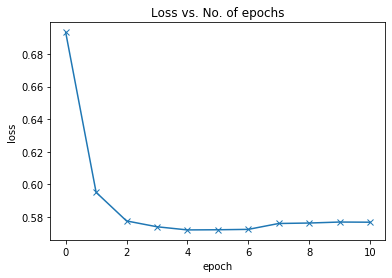

In [19]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

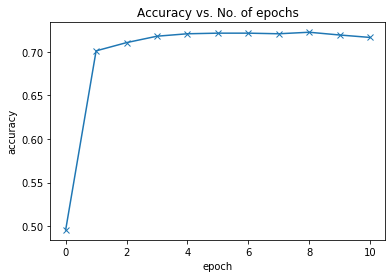

In [20]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [21]:
class SarcasmFeedForward(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_dimension, hidden_size, nr_classes):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocabulary_size, embedding_dimension)
        # hidden layer
        self.fc1 = nn.Linear(embedding_dimension, hidden_size)
        # output layer
        self.fc2 = nn.Linear(hidden_size, nr_classes)
        
        self.embedding.weight.data.uniform_(-0.5, 0.5)
        self.fc1.weight.data.uniform_(-0.5, 0.5)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-0.5, 0.5)
        self.fc2.bias.data.zero_()
        
    def forward(self, text):
        text = torch.transpose(text, 0, 1)
        xb = self.embedding(text)
        out = self.fc1(xb)
        out = F.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def training_step(self, batch):
        text, labels = batch 
        out = self(text)                    # Generate predictions
        out = torch.transpose(out, 0, 1)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        text, labels = batch 
        out = self(text)                      # Generate predictions
        out = torch.transpose(out, 0, 1)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [22]:
embedding_dimension = 32
nr_classes = 2
hidden_size = 32

model = SarcasmFeedForward(vocabulary_size, embedding_dimension ,hidden_size, nr_classes).to(device)

In [23]:
epochs = 5
lr = 0.01

history = [evaluate(model, val_dl)]
print(history)

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 1e-3)
history += fit(model, epochs, lr, train_dl, val_dl, opt)

D:\Softwares\Anaconda\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[{'val_loss': 0.6968271136283875, 'val_acc': 0.477622389793396}]
Epoch [0], val_loss: 0.5586, val_acc: 0.7126
Epoch [1], val_loss: 0.5450, val_acc: 0.7203
Epoch [2], val_loss: 0.5315, val_acc: 0.7192
Epoch [3], val_loss: 0.5328, val_acc: 0.7192
Epoch [4], val_loss: 0.5357, val_acc: 0.7168


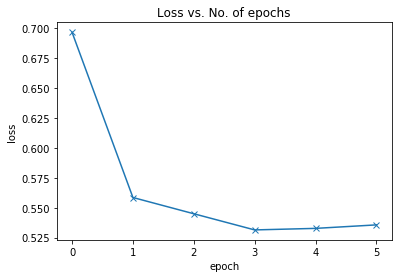

In [24]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

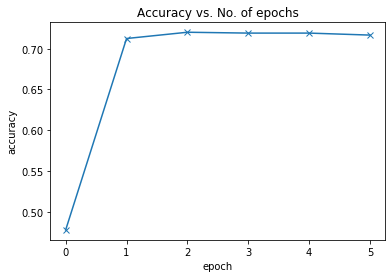

In [25]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [264]:
class SarcasmCnn(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_dimension, nr_classes, nr_filters, window_sizes):
        super(SarcasmCnn, self).__init__()
        self.embedding = nn.EmbeddingBag(vocabulary_size, embedding_dimension)
        self.convs = nn.ModuleList([nn.Conv2d(1, nr_filters, [window_size, embedding_dimension], padding=(window_size - 1, 0))
                                    for window_size in window_sizes])
        print(self.convs)
        self.fc = nn.Linear(nr_filters * len(window_sizes), nr_classes)
        
    def forward(self, text):
        x = self.embedding(text)
        x = torch.unsqueeze(x, 0)
        x = torch.unsqueeze(x, 0)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out = F.softmax(x, dim = 1)
        return out
    
    def training_step(self, batch):
        text, labels = batch 
        out = self(text)                    # Generate predictions
        #out = out.view(-1, out.shape[0]*out.shape[1])
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        text, labels = batch 
        out = self(text)                      # Generate predictions
        #print(out, labels)
        #out = out.view(-1, out.shape[0]*out.shape[1])
        #print(out, labels)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [265]:
train_iterator, val_iterator = Iterator.splits((train, val),
                                                batch_sizes=(1, 1),
                                                sort_key=lambda x: len(x.headline),
                                                sort_within_batch=False)
train_dl = Wrapper(train_iterator, 'headline', 'sarcasm')
val_dl = Wrapper(val_iterator, 'headline', 'sarcasm')

In [266]:
embedding_dimension = 5
nr_classes = 2
nr_filters = 10
window_sizes=(2,3,4,5)

model = SarcasmCnn(vocabulary_size, embedding_dimension, nr_classes, nr_filters, window_sizes).to(device)

ModuleList(
  (0): Conv2d(1, 10, kernel_size=[2, 5], stride=(1, 1), padding=(1, 0))
  (1): Conv2d(1, 10, kernel_size=[3, 5], stride=(1, 1), padding=(2, 0))
  (2): Conv2d(1, 10, kernel_size=[4, 5], stride=(1, 1), padding=(3, 0))
  (3): Conv2d(1, 10, kernel_size=[5, 5], stride=(1, 1), padding=(4, 0))
)


In [267]:
epochs = 10
lr = 0.1

history = [evaluate(model, val_dl)]
print(history)

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 1e-3)
history += fit(model, epochs, lr, train_dl, val_dl, opt)

[{'val_loss': 0.6921582818031311, 'val_acc': 0.5125874280929565}]
Epoch [0], val_loss: 0.5417, val_acc: 0.7514
Epoch [1], val_loss: 0.5170, val_acc: 0.7794
Epoch [2], val_loss: 0.4937, val_acc: 0.8087
Epoch [3], val_loss: 0.4903, val_acc: 0.8136
Epoch [4], val_loss: 0.4781, val_acc: 0.8280
Epoch [5], val_loss: 0.4784, val_acc: 0.8262
Epoch [6], val_loss: 0.4758, val_acc: 0.8329
Epoch [7], val_loss: 0.4750, val_acc: 0.8308
Epoch [8], val_loss: 0.4743, val_acc: 0.8318
Epoch [9], val_loss: 0.4721, val_acc: 0.8353


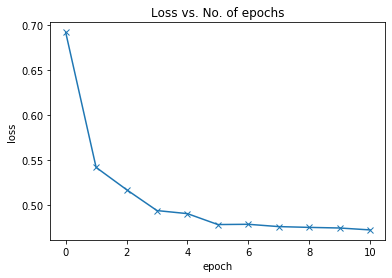

In [268]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

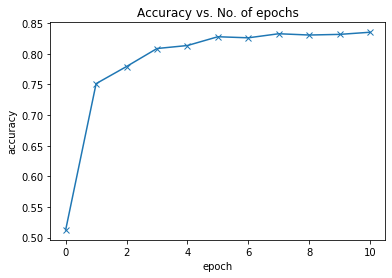

In [269]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [270]:
for i, (text, label) in enumerate(test_dl):
    print(test[i].headline)
    print(text.view(1, text.shape[0]))
    print('Label:', label, ', Predicted:', predict(text, model), '\n')

['mom', 'starting', 'to', 'fear', "son's", 'web', 'series', 'closest', 'thing', 'she', 'will', 'have', 'to', 'grandchild']
tensor([[ 134,  672,    2, 1002, 1742, 2876,  627, 4540,  215,  107,   38,   42,
            2,    0]])
Label: tensor([1]) , Predicted: 1 

['man', 'having', 'a', 'great', 'time', 'will', 'soon', 'have', 'to', 'apologize', 'to', 'everyone']
tensor([[  13,  312,    7,  307,   54,   38, 1276,   42,    2, 3142,    2,  233]])
Label: tensor([1]) , Predicted: 1 

['police', 'use', 'exact', 'right', 'amount', 'of', 'force', 'to', 'subdue', 'suspect']
tensor([[ 111,  299, 4623,  162, 2135,    3,  824,    2,    0,  832]])
Label: tensor([1]) , Predicted: 0 

['man', 'pretty', 'sure', 'he', 'could', 'run', 'this', 'company', 'into', 'ground', 'way', 'better', 'than', 'boss']
tensor([[  13,  304,  385,   30,   78,  344,   21,  348,   40, 1399,   86,  228,
           69, 1073]])
Label: tensor([1]) , Predicted: 1 

['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'in'

In [282]:
jovian.commit(project='sarcasm-detection-using-news-headlines', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "justcallmerob/sarcasm-detection-using-news-headlines" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/justcallmerob/sarcasm-detection-using-news-headlines


'https://jovian.ml/justcallmerob/sarcasm-detection-using-news-headlines'